Zyfra, a heavy industry and mining company, has requested a prototype model for predicting the amount of gold recovered from their gold ore.  They have provided datasets regarding the purification values of gold (au), silver (ag), and lead (pb) at different stages of purification.  I will be investigating the data to discover the best model to deliver the optimum results, using sMAPE, Linear Regression, and Random Forest models.  

In [1]:
#importing relevant libraries and functions
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
import joblib

In [2]:
au_train = pd.read_csv('/datasets/gold_recovery_train.csv')
au_test = pd.read_csv('/datasets/gold_recovery_test.csv')
au_source = pd.read_csv('/datasets/gold_recovery_full.csv')

display(au_train.info(), au_test.info(), au_source.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


None

None

None

In [3]:
#missing values
au_train_missing = au_train.isnull().sum()
au_test_missing = au_test.isnull().sum()
au_source_missing = au_source.isnull().sum()

display(au_train_missing, au_test_missing, au_source_missing)

date                                            0
final.output.concentrate_ag                    72
final.output.concentrate_pb                    72
final.output.concentrate_sol                  370
final.output.concentrate_au                    71
                                             ... 
secondary_cleaner.state.floatbank5_a_level     85
secondary_cleaner.state.floatbank5_b_air       85
secondary_cleaner.state.floatbank5_b_level     84
secondary_cleaner.state.floatbank6_a_air      103
secondary_cleaner.state.floatbank6_a_level     85
Length: 87, dtype: int64

date                                            0
primary_cleaner.input.sulfate                 302
primary_cleaner.input.depressant              284
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                166
primary_cleaner.state.floatbank8_a_air         16
primary_cleaner.state.floatbank8_a_level       16
primary_cleaner.state.floatbank8_b_air         16
primary_cleaner.state.floatbank8_b_level       16
primary_cleaner.state.floatbank8_c_air         16
primary_cleaner.state.floatbank8_c_level       16
primary_cleaner.state.floatbank8_d_air         16
primary_cleaner.state.floatbank8_d_level       16
rougher.input.feed_ag                          16
rougher.input.feed_pb                          16
rougher.input.feed_rate                        40
rougher.input.feed_size                        22
rougher.input.feed_sol                         67
rougher.input.feed_au                          16
rougher.input.floatbank10_sulfate             257


date                                            0
final.output.concentrate_ag                    89
final.output.concentrate_pb                    87
final.output.concentrate_sol                  385
final.output.concentrate_au                    86
                                             ... 
secondary_cleaner.state.floatbank5_a_level    101
secondary_cleaner.state.floatbank5_b_air      101
secondary_cleaner.state.floatbank5_b_level    100
secondary_cleaner.state.floatbank6_a_air      119
secondary_cleaner.state.floatbank6_a_level    101
Length: 87, dtype: int64

In [4]:
#duplicated values
au_train_dupes = au_train.duplicated().sum()
au_test_dupes = au_test.duplicated().sum()
au_source_dupes = au_source.duplicated().sum()

display(au_train_dupes, au_test_dupes, au_source_dupes)

0

0

0

Looks like there are lots of missing values, but zero duplicated values in the datasets.  We'll tackle missing values later.  First, let's verify the recovery formula on the data as presented. 

In [5]:
# Define necessary columns for recovery verification
recovery_cols = ['rougher.output.concentrate_au',
    'rougher.input.feed_au',
    'rougher.output.tail_au',
    'rougher.output.recovery']

# Use a clearer name for the DataFrame subset used in verification
recovery_check_df = au_train.dropna(subset=recovery_cols)

# Extract the formula components
C = recovery_check_df['rougher.output.concentrate_au']
F = recovery_check_df['rougher.input.feed_au']
T = recovery_check_df['rougher.output.tail_au']

# Calculate recovery manually
recovery_manual = (C * (F - T)) / (F * (C - T)) * 100

# Filter for valid numerical values only
valid_mask = recovery_manual.notna() & np.isfinite(recovery_manual)
recovery_manual_clean = recovery_manual[valid_mask]
recovery_actual_clean = recovery_check_df.loc[valid_mask, 'rougher.output.recovery']

# Compute MAE for verification
mae_verification = mean_absolute_error(recovery_actual_clean, recovery_manual_clean)
mae_verification


9.303415616264301e-15

An MAE of 9.303e-15 is a a very good indicator that this recovery formula is reliable.  Let's take a look at the differences between the test set and the training and source sets.

In [6]:
# Identify columns in train but not in test
train_only_cols = sorted(set(au_train.columns) - set(au_test.columns))

# Check their data types
train_only_info = pd.DataFrame({
    "Column Name": train_only_cols,
    "Data Type": [au_train[col].dtype for col in train_only_cols]
})

display(train_only_info)


,Column Name,Data Type
0,final.output.concentrate_ag,float64
1,final.output.concentrate_au,float64
2,final.output.concentrate_pb,float64
3,final.output.concentrate_sol,float64
4,final.output.recovery,float64
5,final.output.tail_ag,float64
6,final.output.tail_au,float64
7,final.output.tail_pb,float64
8,final.output.tail_sol,float64
9,primary_cleaner.output.concentrate_ag,float64


There are 33 float64 type columns not present in the test set.  These appear to be target variables, which if included in the train set, would introduce data leakage.

In [7]:
#missing values as a percentage to determine dropping or replacing w/ median
missing_summary = pd.DataFrame({
    "Full Missing %": au_source.isnull().mean() * 100,
    "Train Missing %": au_train.isnull().mean() * 100,
    "Test Missing %": au_test.isnull().mean() * 100,
}).round(2)
missing_summary = missing_summary[missing_summary.max(axis=1) > 0]
missing_summary.head()

,Full Missing %,Train Missing %,Test Missing %
final.output.concentrate_ag,0.39,0.43,NaN
final.output.concentrate_au,0.38,0.42,NaN
final.output.concentrate_pb,0.38,0.43,NaN
final.output.concentrate_sol,1.69,2.19,NaN
final.output.recovery,8.64,9.02,NaN


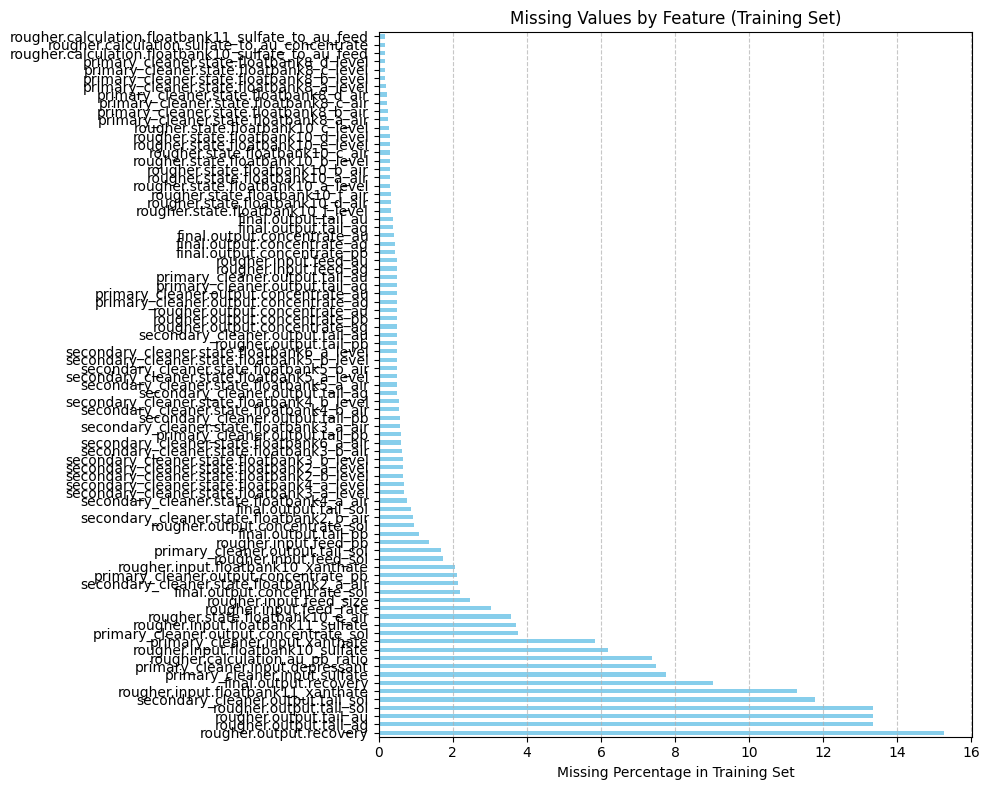

In [8]:
#sort missing values by percentage in training data for visualization
missing_summary_sorted = missing_summary.sort_values("Train Missing %", ascending=False)

#slot missing value percentages
plt.figure(figsize=(10, 8))
missing_summary_sorted["Train Missing %"].plot(kind="barh", color="skyblue")
plt.xlabel("Missing Percentage in Training Set")
plt.title("Missing Values by Feature (Training Set)")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Looks like the vast majority of columns containing missing values are missing about 4% of the column.  For those columns whose percentage is >4%, let's investigate the distribution for skew.

In [9]:
# Identify columns based on missing percentage thresholds
low_missing_cols = missing_summary[missing_summary["Train Missing %"] < 4].index.tolist()
high_missing_cols = missing_summary[missing_summary["Train Missing %"] >= 4].index.tolist()

# Fill NaNs with median for low missing columns in the training dataset
au_train[low_missing_cols] = au_train[low_missing_cols].fillna(au_train[low_missing_cols].median())


Filled the missing values with the median for columns missing <4% of the total values.  Let's investigate the columns which present >4% missing values to determine best handling method.

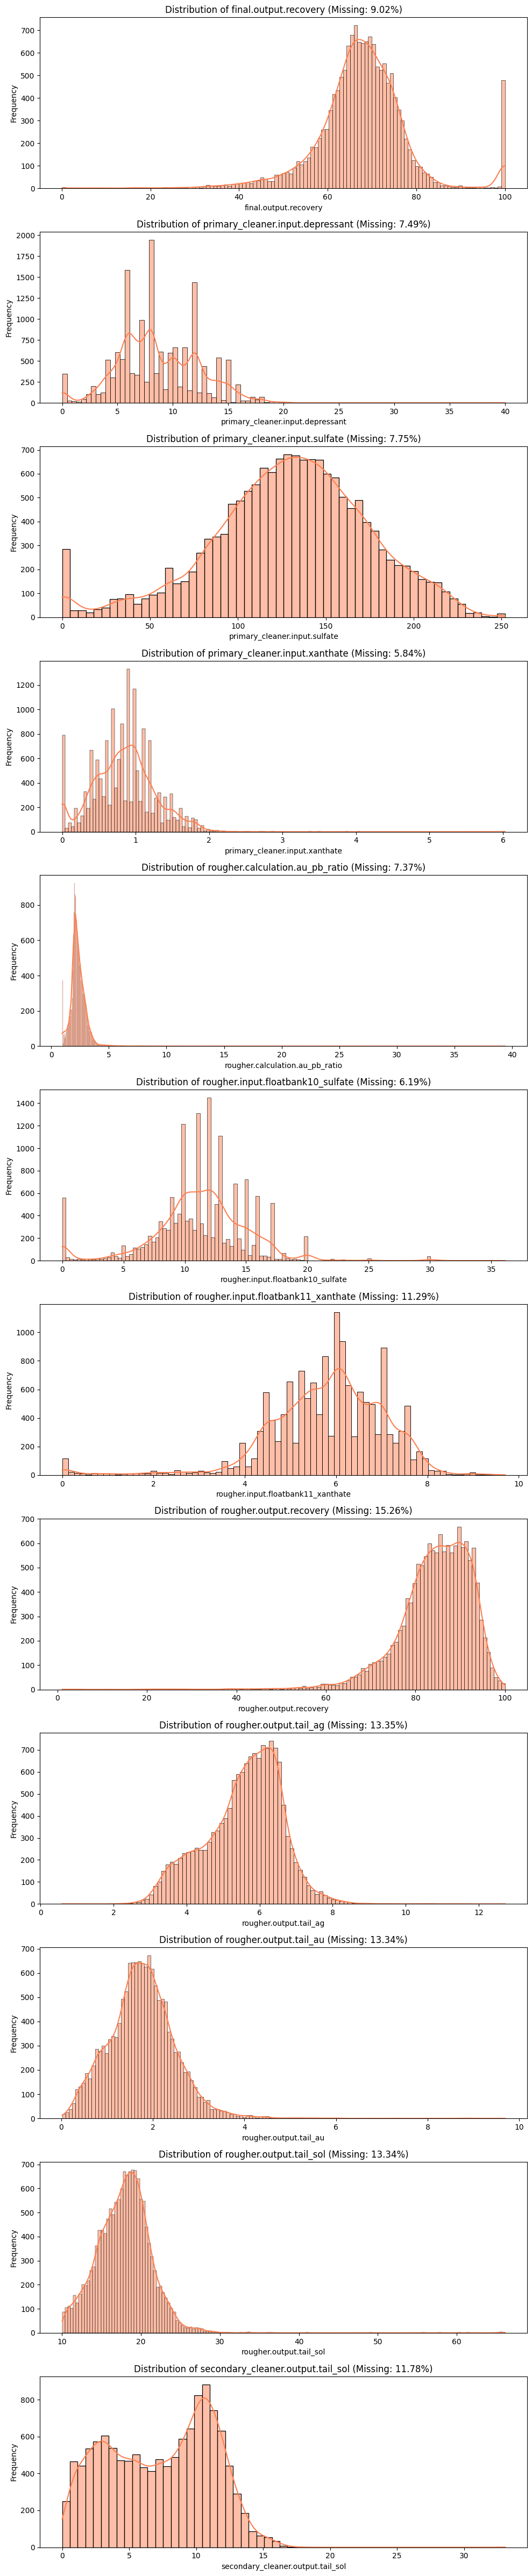

In [10]:
#plot distributions for high missing columns
num_cols = len(high_missing_cols)
fig, axes = plt.subplots(nrows=num_cols, ncols=1, figsize=(10, 4 * num_cols))

for i, col in enumerate(high_missing_cols):
    drop_zero_train = au_train[col].dropna()
    drop_zero_train = drop_zero_train[drop_zero_train > 1e-6]
    sns.histplot(drop_zero_train, kde=True, ax=axes[i], color='coral')
    axes[i].set_title(f'Distribution of {col} (Missing: {missing_summary.loc[col, "Train Missing %"]:.2f}%)')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

Most of these columns can be filled with the median values.  Some columns are bimodal/multimodal requiring additional analysis.  Those columns are 
- "primary_cleaner.input.depressant", 
- "rougher.input.floatbank10_sulfate", 
- "rougher.input.floatbank11_xanthate", 
- "secondary_cleaner.output.tail_sol".

Some values at '0' appear to be spiking, but those values are simply near-0 values, and are still significant data.

In [11]:

# Define columns for further investigation

investigate_cols = ["primary_cleaner.input.depressant",
    "rougher.input.floatbank10_sulfate",
    "rougher.input.floatbank11_xanthate",
    "secondary_cleaner.output.tail_sol"]

# Determine other high-missing columns
high_missing_cols = missing_summary[missing_summary["Train Missing %"] >= 4].index.tolist()
remaining_high_missing_cols = list(set(high_missing_cols) - set(investigate_cols))

# Impute remaining high-missing columns with median
au_train[remaining_high_missing_cols] = au_train[remaining_high_missing_cols].fillna(
    au_train[remaining_high_missing_cols].median())

display(au_train.isnull().sum())

date                                          0
final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_sol                  0
final.output.concentrate_au                   0
                                             ..
secondary_cleaner.state.floatbank5_a_level    0
secondary_cleaner.state.floatbank5_b_air      0
secondary_cleaner.state.floatbank5_b_level    0
secondary_cleaner.state.floatbank6_a_air      0
secondary_cleaner.state.floatbank6_a_level    0
Length: 87, dtype: int64

The training set, less the previously mentioned columns needing further investigation, now has all missing values filled.  Let's take a final look at these remaining columns.

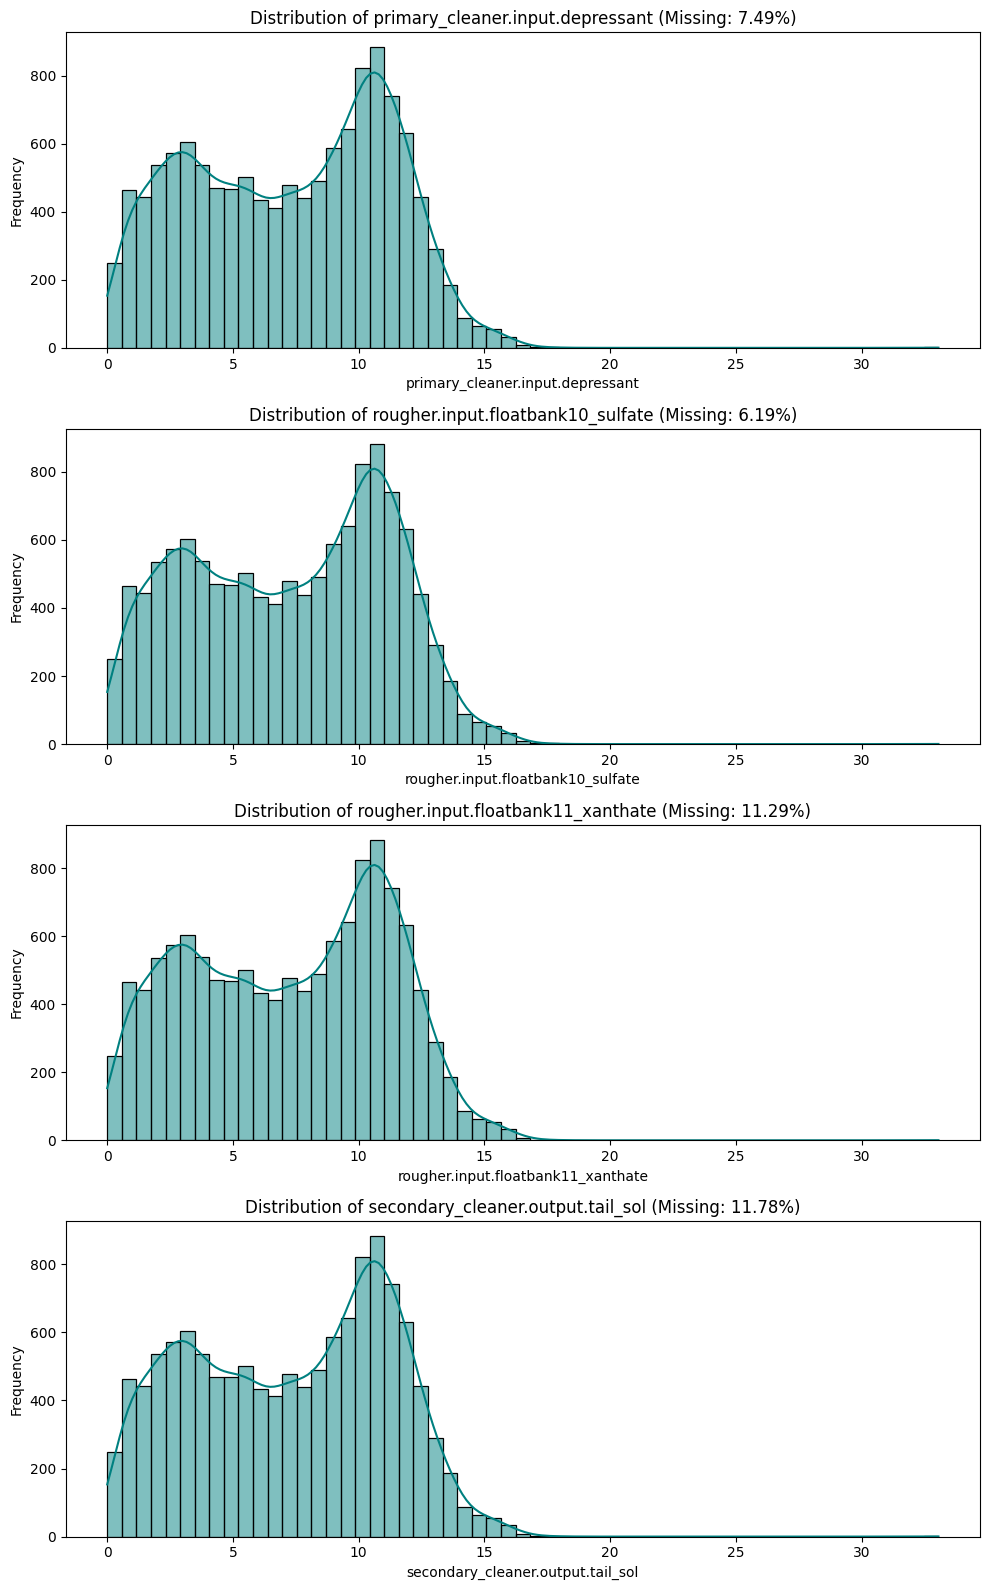

In [12]:
# Plot distributions of the four columns to be investigated
num_cols = len(investigate_cols)
fig, axes = plt.subplots(nrows=num_cols, ncols=1, figsize=(10, 4 * num_cols))

for i, col in enumerate(investigate_cols):
    sns.histplot(drop_zero_train, kde=True, ax=axes[i], color='teal')
    axes[i].set_title(f'Distribution of {col} (Missing: {missing_summary.loc[col, "Train Missing %"]:.2f}%)')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

While there is some skewing and grouping issues, the median is still the best option to fill the missing values.

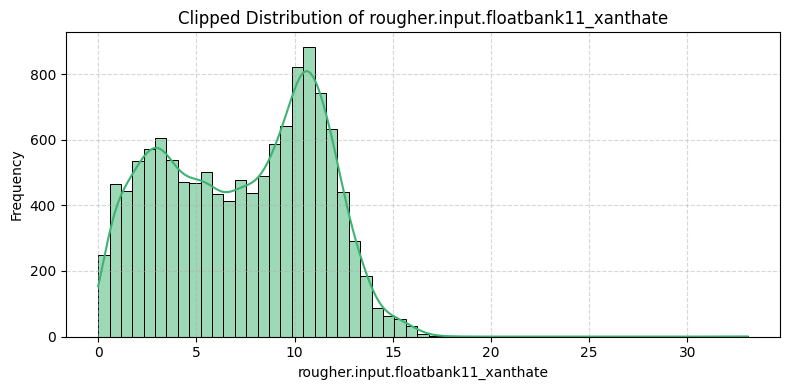

In [13]:
# Fill all four investigated columns with the median
for col in investigate_cols:
    median_val = au_train[col].median()
    au_train[col] = au_train[col].fillna(median_val)

# Clip outliers in 'rougher.input.floatbank11_xanthate' using IQR
col = 'rougher.input.floatbank11_xanthate'
Q1 = au_train[col].quantile(0.25)
Q3 = au_train[col].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

au_train[col] = au_train[col].clip(lower=lower_bound, upper=upper_bound)

# Plot to confirm the effect of clipping
plt.figure(figsize=(8, 4))
sns.histplot(drop_zero_train, kde=True, color='mediumseagreen')
plt.title(f'Clipped Distribution of {col}')
plt.xlabel(col)
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


All missing values are now replaced with the median and outliers have been removed to avoid skewing the data.  Let's do the same for the test and source datasets.

In [14]:
# Recalculate medians from numeric columns only
train_medians = au_train.select_dtypes(include='number').median()

# Drop non-numeric columns from the datasets (like 'date') when filling
common_test_cols = train_medians.index.intersection(au_test.columns)
common_source_cols = train_medians.index.intersection(au_source.columns)

# Impute using training medians
au_test[common_test_cols] = au_test[common_test_cols].fillna(train_medians[common_test_cols])
au_source[common_source_cols] = au_source[common_source_cols].fillna(train_medians[common_source_cols])

# Clip the outlier in test and source for 'rougher.input.floatbank11_xanthate' using train IQR
Q1 = au_train['rougher.input.floatbank11_xanthate'].quantile(0.25)
Q3 = au_train['rougher.input.floatbank11_xanthate'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

if 'rougher.input.floatbank11_xanthate' in au_test.columns:
    au_test['rougher.input.floatbank11_xanthate'] = au_test['rougher.input.floatbank11_xanthate'].clip(lower=lower_bound, upper=upper_bound)

if 'rougher.input.floatbank11_xanthate' in au_source.columns:
    au_source['rougher.input.floatbank11_xanthate'] = au_source['rougher.input.floatbank11_xanthate'].clip(lower=lower_bound, upper=upper_bound)

Filled missing values in au_test and au_source withe median values and removed outliers.  Now that we have clean datasets for train, test, and source, let's begin analyzing the present data.

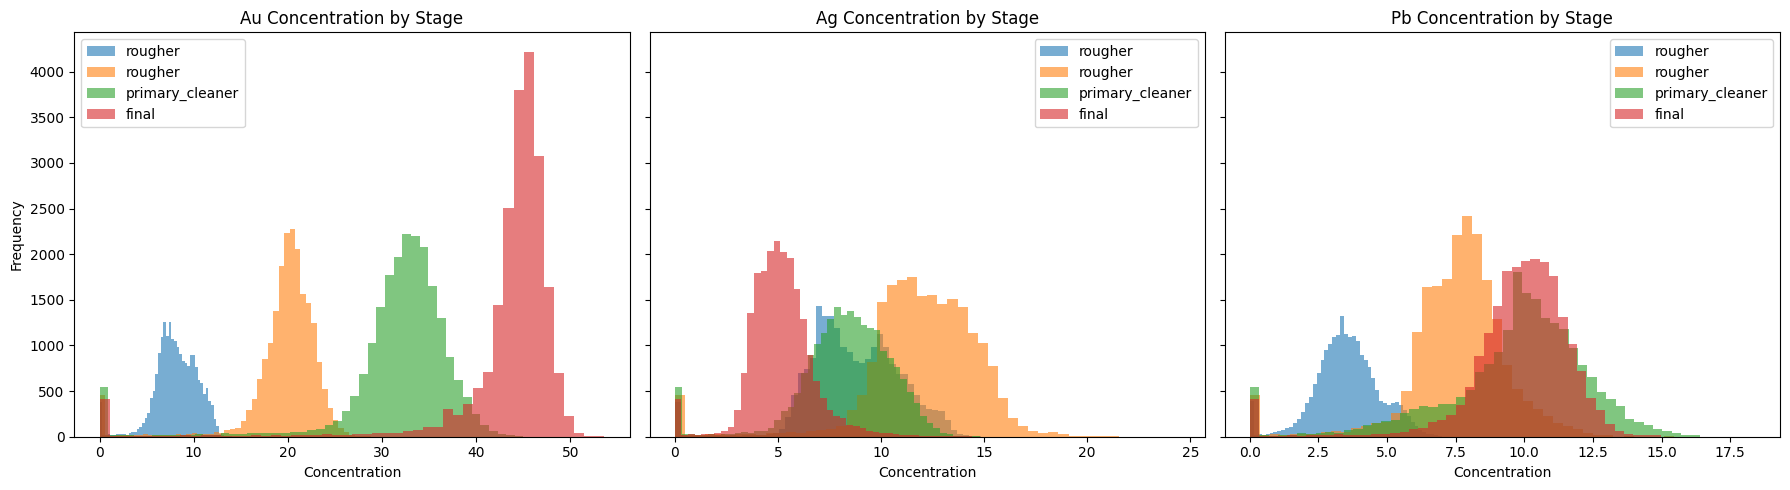

In [25]:
#histograms for gold (au), silver (ag), and lead (pb) concentrations depending on purification stage
au_stages = ['rougher.input.feed_au',
    'rougher.output.concentrate_au',
    'primary_cleaner.output.concentrate_au',
    'final.output.concentrate_au']

ag_stages = ['rougher.input.feed_ag',
    'rougher.output.concentrate_ag',
    'primary_cleaner.output.concentrate_ag',
    'final.output.concentrate_ag']

pb_stages = ['rougher.input.feed_pb',
    'rougher.output.concentrate_pb',
    'primary_cleaner.output.concentrate_pb',
    'final.output.concentrate_pb']

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
for i, (metal, cols) in enumerate(zip(['Au', 'Ag', 'Pb'], [au_stages, ag_stages, pb_stages])):
    ax = axes[i]
    for col in cols:
        if col in au_source.columns:
            label = col.split('.')[0]
            drop_zero_source = au_source[col].dropna()
            drop_zero_source = drop_zero_source[drop_zero_source > 1e-6]
            ax.hist(drop_zero_source, bins=50, alpha=0.6, label=label)
    ax.set_title(f'{metal} Concentration by Stage')
    ax.set_xlabel('Concentration')
    ax.legend()
    if i == 0:
        ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Gold concentration appears to increase significantly as it passes through each purification stage.  Silver concentration is highest in the secondary rougher stage (orange), but the final stage yields the lowest concentration.  Lead concentration appears similar to silver in the secondary rougher stage, but has a higher concentration in the primary cleaner and final stages as compared to silver.  Gold concentrations, however, appear to behave normally and as expected. 

Again, the cluster of values at '0' are near-0 values and are still significant.

Let's compare the particle size distributions between the training set and the test set to reveal if the distributions vary significantly.

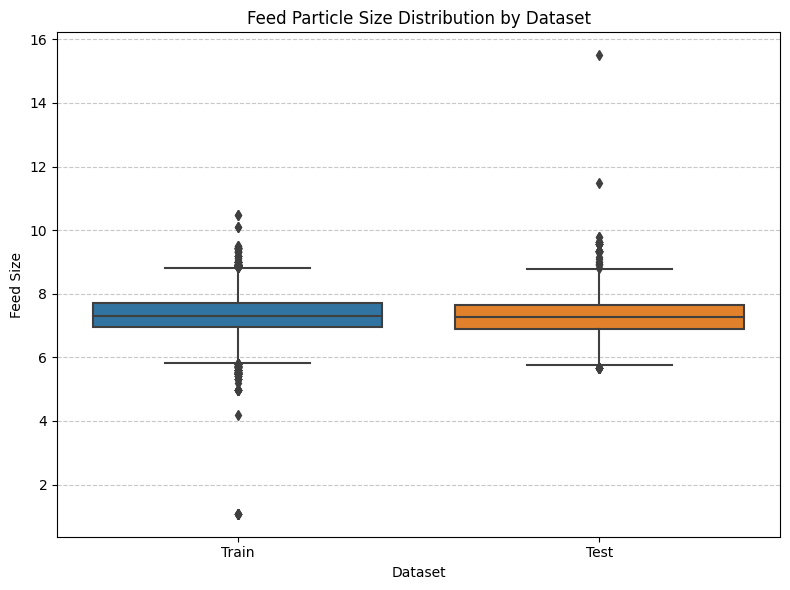

In [16]:
# combined boxplot for distribution comparison
train_box = pd.DataFrame({
    'Feed Size': au_train['primary_cleaner.input.feed_size'],
    'Dataset': 'Train'})
test_box = pd.DataFrame({
    'Feed Size': au_test['primary_cleaner.input.feed_size'],
    'Dataset': 'Test'})
combined_box = pd.concat([train_box, test_box], ignore_index=True).dropna()

plt.figure(figsize=(8, 6))
sns.boxplot(x='Dataset', y='Feed Size', data=combined_box)
plt.title('Feed Particle Size Distribution by Dataset')
plt.ylabel('Feed Size')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

The medians are nearly identical between both datasets.  The Test set has more high outliers while the Train set has more low outliers.  There does not appear to be any skew regarding the medians.

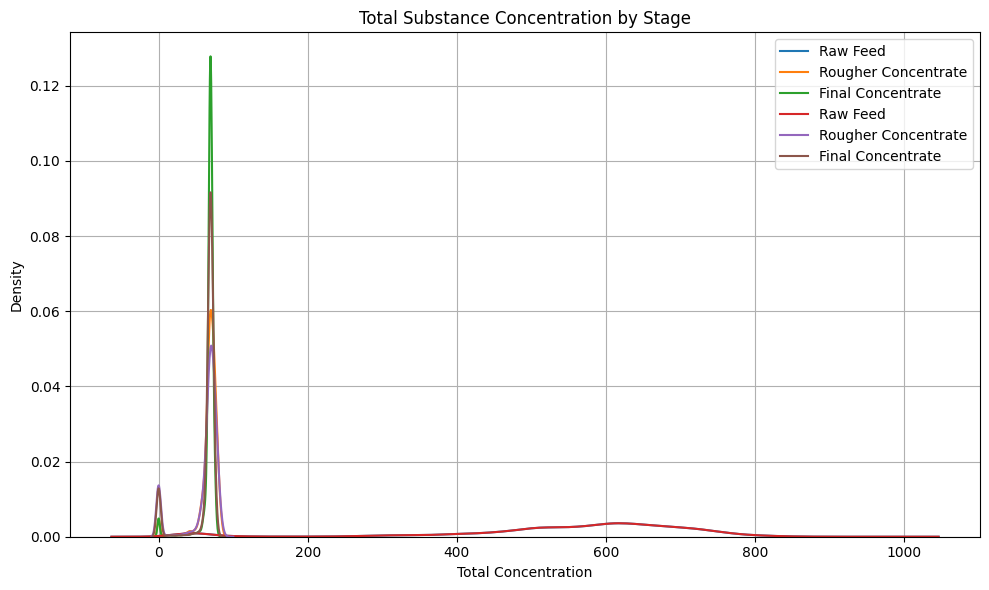

In [17]:
#kde plot for total concentrations at each stage
stage_prefixes = {"raw_feed": "rougher.input.feed_",
    "rougher_concentrate": "rougher.output.concentrate_",
    "final_concentrate": "final.output.concentrate_"}

# extract all substances involved at each stage
substances = set()
for prefix in stage_prefixes.values():
    substances.update([col.replace(prefix, '') for col in au_source.columns if col.startswith(prefix)])

# calculate total concentration for each stage
total_concentration = {}
for stage, prefix in stage_prefixes.items():
    cols = [prefix + substance for substance in substances if prefix + substance in au_source.columns]
    total_concentration[stage] = au_source[cols].sum(axis=1)

# combine into a DataFrame for plotting
concentration_df = pd.DataFrame(total_concentration)

# plot distributions of total concentrations at each stage
plt.figure(figsize=(10, 6))
for stage in concentration_df.columns:
    stage_data = concentration_df[stage].dropna()
    stage_data = stage_data[stage_data > 1e-6]  #removing zeros and near-zeros
    sns.kdeplot(stage_data, label=stage.replace("_", " ").title())
sns.kdeplot(concentration_df["raw_feed"].dropna(), label="Raw Feed")
sns.kdeplot(concentration_df["rougher_concentrate"].dropna(), label="Rougher Concentrate")
sns.kdeplot(concentration_df["final_concentrate"].dropna(), label="Final Concentrate")
plt.title("Total Substance Concentration by Stage")
plt.xlabel("Total Concentration")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


As expected, the Raw Feed has the lowest density of metals.  The next stage, Rougher Concentrate, shows high density, indicating initial purification was effective.  The Final Concentrate shows an even more narrow distribution indicating subsequent purification was effective.

Let's move on to building the final model for evaluating sMAPE.

In [18]:
#defining sMAPE
def smape(y_true, y_pred):
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    with np.errstate(divide='ignore', invalid='ignore'):
        smape_values = np.where(denominator != 0, numerator / denominator, 0)
    return 100 * np.mean(smape_values)

#defining final sMAPE
def final_smape(y_true_rougher, y_pred_rougher, y_true_final, y_pred_final):
    smape_rougher = smape(y_true_rougher, y_pred_rougher)
    smape_final = smape(y_true_final, y_pred_final)
    return 0.25 * smape_rougher + 0.75 * smape_final

Let's begin training and testing a couple different models using au_train and au_test, starting with a baseline model, Linear Regression.

In [19]:
#linear regression model, iteration 1
#defining targets
target_rougher = 'rougher.output.recovery'
target_final = 'final.output.recovery'

#drop target and calculation-only columns from features
features_to_exclude = [target_rougher, target_final] + [col for col in au_train.columns if 'calculation' in col or 'date' in col or 'output' in col]

feature_columns = [col for col in au_train.columns if col not in features_to_exclude]

#extract training data
X = au_train[feature_columns]
y_rougher = au_train[target_rougher]
y_final = au_train[target_final]

#using pipeline to streamline fit, predict
lr_pipeline = Pipeline([('scaler', StandardScaler()), ('regressor', LinearRegression())])

#cross-validation using kfold
cv = KFold(n_splits=3, shuffle=True, random_state=42)

#cross-validated predictions for both targets
y_pred_rougher = cross_val_predict(lr_pipeline, X, y_rougher, cv=cv)
y_pred_final = cross_val_predict(lr_pipeline, X, y_final, cv=cv)

#calculate sMAPE scores
baseline_final_smape = final_smape(y_rougher, y_pred_rougher, y_final, y_pred_final)
baseline_final_smape

10.173091690533766

Linear Regression model returned a baseline sMAPE score of 10.17.  Let's see if we can improve the score using a RandomForest model.

In [20]:
#apply mask to drop NaNs from target columns
target_mask = y_rougher.notna() & y_final.notna()
X_safe = X.loc[target_mask]
y_rougher_safe = y_rougher.loc[target_mask]
y_final_safe = y_final.loc[target_mask]

#define pipeline with built-in imputation for safety
rf_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1))])

#perform cross-validated predictions
y_pred_rougher_rf = cross_val_predict(rf_pipeline, X_safe, y_rougher_safe, cv=cv)
y_pred_final_rf = cross_val_predict(rf_pipeline, X_safe, y_final_safe, cv=cv)

#calculate final sMAPE for RandomForest
rf_final_smape = final_smape(y_rougher_safe, y_pred_rougher_rf, y_final_safe, y_pred_final_rf)
rf_final_smape


8.263483723805983

Random Forest Regressor model returned an sMAPE score of 8.26 which is significant improvement over the baseline Linear Regression model.  Let's tune the Random Forest.

In [21]:
#tuning random forest to improve sMAPE score
#define feature matrix and target
target_final = 'final.output.recovery'
features_to_exclude = [
    'rougher.output.recovery', 'final.output.recovery'
] + [col for col in au_train.columns if 'calculation' in col or 'date' in col or 'output' in col]

feature_columns = [col for col in au_train.columns if col not in features_to_exclude]
X = au_train[feature_columns]
y_final = au_train[target_final]

#drop missing targets
mask = y_final.notna()
X_safe = X.loc[mask]
y_final_safe = y_final.loc[mask]

#CV setup
cv = KFold(n_splits=3, shuffle=True, random_state=42)

configs = [{'n_estimators': 50, 'max_depth': 5},
    {'n_estimators': 50, 'max_depth': 10},
    {'n_estimators': 100, 'max_depth': 10}]

results = []

for config in configs:
    pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('regressor', RandomForestRegressor(
            n_estimators=config['n_estimators'],
            max_depth=config['max_depth'],
            random_state=42,
            n_jobs=-1))])
    y_pred = cross_val_predict(pipeline, X_safe, y_final_safe, cv=cv)
    score = smape(y_final_safe, y_pred)
    results.append((config, score))

results


[({'n_estimators': 50, 'max_depth': 5}, 9.197930720170126),
 ({'n_estimators': 50, 'max_depth': 10}, 8.169989879878335),
 ({'n_estimators': 100, 'max_depth': 10}, 8.133450336942158)]

In [22]:
#training final model using tuned parameters
#define final targets
target_rougher = 'rougher.output.recovery'
target_final = 'final.output.recovery'

#filter features (exclude output/calculation/date columns)
features_to_exclude = [target_rougher, target_final] + [col for col in au_train.columns if 'calculation' in col or 'date' in col or 'output' in col]
feature_columns = [col for col in au_train.columns if col not in features_to_exclude]

#prepare training data
mask = au_train[target_rougher].notna() & au_train[target_final].notna()
X_train = au_train.loc[mask, feature_columns]
y_train_rougher = au_train.loc[mask, target_rougher]
y_train_final = au_train.loc[mask, target_final]

#prepare test data
X_test = au_test[feature_columns]

#define pipeline with tuned hyperparameters
final_rf_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        n_jobs=-1))])

#train separate models for rougher and final recovery
final_rf_pipeline.fit(X_train, y_train_rougher)
rougher_preds = final_rf_pipeline.predict(X_test)

final_rf_pipeline.fit(X_train, y_train_final)
final_preds = final_rf_pipeline.predict(X_test)

#output shape and sample predictions
rougher_preds[:5], final_preds[:5]


(array([86.14096868, 82.37847185, 84.23048578, 85.85502813, 85.93469059]),
 array([69.51205173, 68.4840317 , 69.48648977, 69.52545948, 69.89016943]))

The Random Forest Regressor model delivered the best sMAPE score of 8.13 compared the baseline score of 10.17.  Let's save the final recovery model.

In [23]:
#saving model via joblib
joblib.dump(final_rf_pipeline, 'final_rf_model_final_output.pkl')

['final_rf_model_final_output.pkl']

Using sMAPE scores to drive model evaluation and tuning, I have developed a Random Forest model to predict the amount of gold recovered from the ore Zyfra mines.  The baseline Linear Regression model yielded a sMAPE of 10.17, which was improved upon by pursuing and tuning a Random Forest Regressor model.  This final model yielded a sMAPE of 8.13, a significant improvement over the Linear Regression model.

Zyfra now has the ability to more effectively predict the amount of gold they recover from the harvested ore